# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


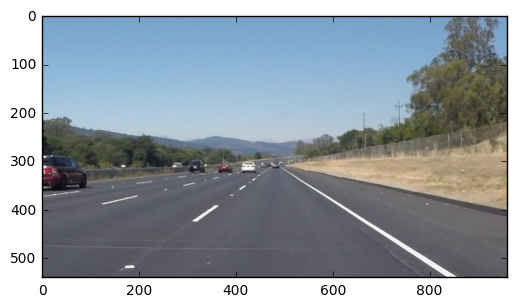

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.1):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Some **additional** help function used in this project. 

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
test_images = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

In [5]:
def filter_yellow_white(image):
    """ 
    A simple filter that detects the presence of white and yellow lanes
    in the image. 
    
    It first converts the image in HSV colorspace ( A better option might be HSL), 
    the masks color for yello and blue. 
    
    `image` : The 3-channel RGB image. 
    """

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Yello color range
    lower_yellow = np.array([20, 100, 200])
    upper_yellow = np.array([85, 255, 255])

    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    res = cv2.bitwise_and(image, image, mask=mask)

    # White color range. 
    sensitivy = 45
    lower_white = np.array([0, 0, 255 - sensitivy])
    upper_white = np.array([255, sensitivy, 255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    res2 = cv2.bitwise_and(image, image, mask=mask)
    
    # Finally combine the white and yello image to get a single image. 
    return cv2.bitwise_or(res, res2)

def reset_globals():
    """
     Reset global state
    """
    global g_x1r
    global g_x2r
    global g_x1l
    global g_x2l
    global g_ml
    global g_mr
    
    g_x1r = 0
    g_x2r = 0
    g_x1l = 0
    g_x2l = 0
    g_ml = 0
    g_mr = 0

def compute_slope(slopes, candidate_slope, prev_slope=0, weight=0.5):
    """
    find slope based on a candidate slope parameter
    """
    
    if len(slopes) < 1:
        return prev_slope, prev_slope 

    slope = prev_slope
    if slopes[0] < 0:
        slope = slopes[np.abs(np.abs(slopes) - candidate_slope).argmin()]
    else:
        slope = slopes[np.abs(slopes - candidate_slope).argmin()]
    
    weighted_slope = slope

    if prev_slope != 0:
        weighted_slope = (1 - weight) * prev_slope + (weight * slope)
    
    return  weighted_slope, slope

def compute_lane_line(line, slope, prev_x1, y,  weight=0.5):
    
    if len(line) == 0:
        return prev_x1, y
        
    x1, y1, x2, y2 = line[0]
        
    b = y2 - slope * x2
    
    x1 = (y - b) / slope
    
    if prev_x1 != 0:
        x1 = (1 - weight) * prev_x1 + (weight * x1)
            
    return x1, b
    

def detect_and_track_lanes(img, lines, slope_t0 = (0, 0), xcord_t0=(0, 0, 0, 0)):
    result = []
    
    # Lets get rid of the extra dimension return by cv hough function
    lines = np.squeeze(lines, axis=(1))

    # Vectorized slope computation from all the detected lines. 
    delta = lines.dot(np.array([0, 1, 1, 0, 0, -1, -1, 0]).reshape(4, 2))
    llen = np.sqrt(delta[:, 0]**2 + delta[:, 1]**2)
    slope = delta[:, 0] / delta[:, 1]
        
    best_slope = abs(slope[np.argmax(llen)])
    
    I = slope > 1e-3
    I2 = slope < -1e-3
    
    right_lanes = slope[I]
    left_lanes = slope[I2]
        
    r_weighted_slope, rslope  = compute_slope(right_lanes, best_slope, slope_t0[0])
    l_weighted_slope, lslope = compute_slope(left_lanes, best_slope, slope_t0[1])

    y1r = img.shape[0]
    y1l = img.shape[0]
    
    x1r, br = compute_lane_line(lines[slope==rslope], r_weighted_slope, xcord_t0[0], y1r)
    x1l, bl = compute_lane_line(lines[slope==lslope], l_weighted_slope, xcord_t0[1], y1l)
    
    x2r = (bl - br) / (r_weighted_slope - l_weighted_slope)
    x2l = x2r
    
    if xcord_t0[2] != 0:
        x2r = (1 - 0.5) * xcord_t0[2] + (x2r * 0.5)
        x2l = x2l
        
    y2l = l_weighted_slope * x2r + bl
    y2r = y2l
    
    result.append([int(v) for v in [x1r, y1r, x2r, y2r]])
    result.append([int(v) for v in [x1l, y1l, x2l, y2l]])
    
    
    return np.array(result), l_weighted_slope, r_weighted_slope, x1r, x1l, x2r, x2l


def process_image(image):
    """
     The main entry point for 
    """
    global g_ml
    global g_mr
    global g_x1r
    global g_x2r
    global g_x1l
    global g_x2l
    
    image_original = np.copy(image)
    image = filter_yellow_white(image)
    
    imshape = image.shape
    vertices = np.array([[
                (70,imshape[0]),
                (imshape[1]/2, imshape[0]/2), 
                (imshape[1]/2+10, imshape[0]/2), 
                (imshape[1]-70,imshape[0])
            ]], 
                        dtype=np.int32)

    image = region_of_interest(image, vertices)

    image = grayscale(image)
    #image = gaussian_blur(image, kernel_size)
    image = canny(image, low_threshold=50.0, high_threshold=150.0)
    linestt = hough_lines(image, 1, np.pi/180, 30, 10, 10)
    lines = cv2.HoughLinesP(image, 1, np.pi/180,30, np.array([]), minLineLength=20, maxLineGap=5)
    
    lines2, g_ml, g_mr, g_x1r, g_x1l, g_x2r, g_xlr = detect_and_track_lanes(
                image, lines, (g_mr, g_ml), (g_x1r, g_x1l, g_x2r, g_x2l))
    line_img = np.zeros((*image.shape, 3), dtype=np.uint8)
    
    draw_lines(line_img, [lines2], color=[0, 100, 0], thickness=18)
    
    return  weighted_img(line_img, image_original, 0.9, 0.7, 1)


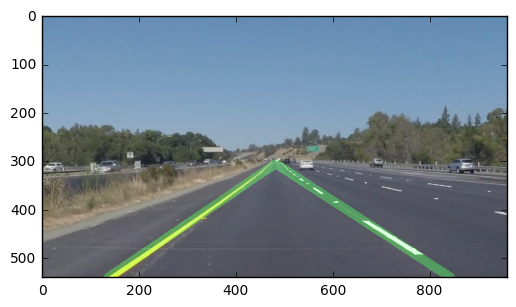

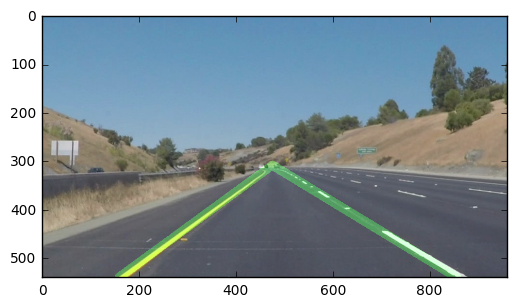

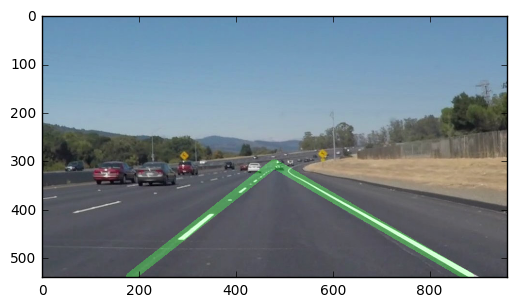

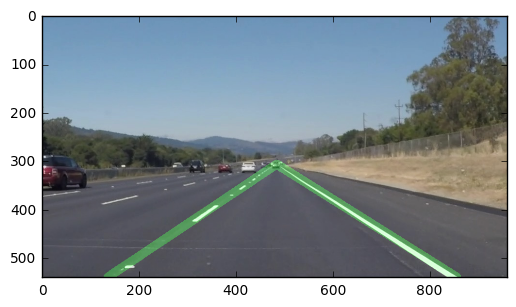

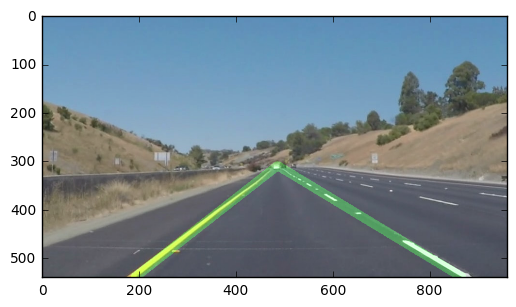

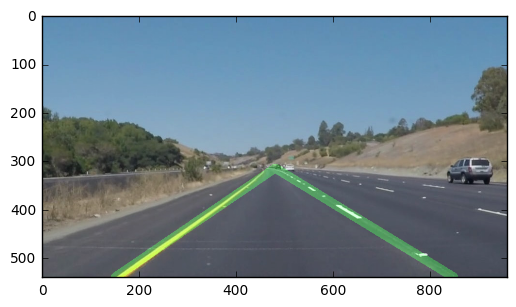

In [6]:
import os


test_images = os.listdir("test_images/")

for im in test_images:
    reset_globals()

    image = mpimg.imread("test_images/%s"%(im))
    image = process_image(image)
    
    plt.figure()
    plt.imshow(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [8]:
# Lets reset global variables
reset_globals()

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 37.1 s, sys: 112 ms, total: 37.3 s
Wall time: 6.06 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
reset_globals()

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:18<00:00, 35.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 58s, sys: 356 ms, total: 1min 58s
Wall time: 19.3 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


** Algorithm **

The lane detection pipeline for this project starts off by finding the yellow and white color lanes in the frame. All parts of the image are masked off except for the possible regions with these color lanes. For added stability, a region of intrest mask is also applied to focus the processing in a region front of the vehicle (camera). The rest of the steps are similar to the lecure. The grayscale image is passed through canny edge detector and hough lane detection algorithm computes lanes based on the canny edge image. The slope of longest line is picked as a candidate lane slope and depending on its sign, the remaining slopes are compared against the candidate slope to find the slope for the opposite lane. A simple weighted smoothing between last frame parameters and current parameters is used to reduce jitterness in the tracking. 

** Reflection **

An autonomous car needs to see where are the road lanes. This task can be accomplished more robustly by combining input from multiple sensors such as laser range finder. However this project is a simple (read fun) attempt at getting the lane lines through a camera image using just basic filters like HSV color map or Hough transformation.

I stopped tuning paramters at a certain point to move on the next lectures. Also,since we have an advanced lane detection project down the road. But, there is a lot of room for improvements in this approach. The algorithm doesn't do a good job under changing brightness level in the image, as evident by the challenge video. The linear model for lanes will not work for curve lines. Since I rely on specifically looking for white/yellow color in the image for tracking, my algorithm will break if lane markings are not existing or two dim to detect. 

A better approach might be to model the road edges better and use a probabilistic model like particle filter or kalman filter to combine measurements from multiple cues : edges, road color, lane markings etc.  In this regard, I did found some existing work (https://www.researchgate.net/publication/251976676_Real-time_lane_detection_by_using_multiple_cues), but its not clear how their particle filter measurement is working. The paper is also not very clear about how good their algorithm work undert different conditions. 

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
reset_globals()

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:10<00:00, 20.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min, sys: 292 ms, total: 1min
Wall time: 11.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Personal Video

Here is a portion of video from my daily commute. I recorded it with a dash camera and also during a previous night slow fall. The yellow line is being detected correcly for most of the frames, but, the white edges are making it harder to reliably find the road edge. In a better approach we would model lane line with some relationship of width between yellow lane or between two white lanes and that might help to eliminate false positive markings.  

In [ ]:
reset_globals()

challenge2_output = 'extra2.mp4'
clip2 = VideoFileClip('commute3_960x540.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge2_output, audio=False)

[MoviePy] >>>> Building video extra2.mp4
[MoviePy] Writing video extra2.mp4


 91%|█████████▏| 824/903 [00:25<00:02, 30.16it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge2_output))